# Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn import preprocessing
import random
from scipy import stats
import sklearn
import csv
import umap
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.decomposition import TruncatedSVD

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Load and unzip the dataset from kaggle.

In [0]:
os.environ['KAGGLE_USERNAME'] = "amarsharma441" 
os.environ['KAGGLE_KEY'] = "1e8ea665c9ae7b3609d572cee03959c3"
!kaggle datasets download -d yufengdev/bbc-fulltext-and-category

  0% 0.00/1.83M [00:00<?, ?B/s]
100% 1.83M/1.83M [00:00<00:00, 123MB/s]


In [0]:
!unzip '/content/bbc-fulltext-and-category.zip'

Archive:  /content/bbc-fulltext-and-category.zip
  inflating: bbc-text.csv            


# Exploring data


In [0]:
dataframe = pd.read_csv('/content/bbc-text.csv')
dataframe.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [0]:
dataframe.tail()

,category,text
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...
2224,sport,souness delight at euro progress boss graeme s...


In [0]:
n_category = len(np.unique(dataframe.category))
n_news = len(dataframe.text)
print('Total number of categories:' + str(n_category))
print('Total number of news:' + str(n_news))

Total number of categories:5
Total number of news:2225


# Processing data

In [0]:
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [0]:
WN_lemmatizer = WordNetLemmatizer()
def lemmatize_sentence(sentence):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:        
            lemmatized_sentence.append(WN_lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [0]:
bad_chars = ['#','%','@','=','+',';', ':','!','*','?','$','1','2','3','4','5','6','7','8','9','0','-','&','>','<','/']

In [0]:
for i in range(n_news):
    text = str(dataframe['text'][i])
    text = ''.join(i for i in text if not i in bad_chars) 
    text = lemmatize_sentence(text)
    dataframe['text'][i] = str(text)

# Vectorizing using TF-IDF

In [0]:
vectorizer = TfidfVectorizer(stop_words='english')
vectors = vectorizer.fit_transform([i for i in dataframe.text[0:2225]]) #will change it later
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
tfidf = pd.DataFrame(dense, columns=feature_names)
print(tfidf.shape)

(2225, 24663)


In [0]:
tfidf.head()

,aa,aaa,aaas,aac,aadc,aaliyah,aaltra,aamir,aan,aara,aarhus,aaron,abacus,abandon,abandonment,abate,abatement,abba,abbas,abbasi,abbey,abbot,abbott,abbreviated,abc,abd,abdellatif,abdication,abdomen,abdominal,abduct,abduction,abdul,abdullah,abdullatif,abebe,abensur,aberavon,aberdeen,aberdeenbased,...,zephyr,zeppelin,zero,zeroeight,zeroemissions,zeta,zetajones,zhang,zhaoxing,zheng,zib,zidane,ziers,zillion,zimbabwe,zinc,zinedine,zip,ziyi,zodiac,zoe,zoellick,zogbia,zola,zomba,zombic,zombie,zombiesleapingoutofshadows,zone,zonealarm,zoom,zooropa,zornotza,zorro,zubair,zuluaga,zurich,zutons,zvonareva,zvyagintsev
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.099834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
tfidf.tail()

,aa,aaa,aaas,aac,aadc,aaliyah,aaltra,aamir,aan,aara,aarhus,aaron,abacus,abandon,abandonment,abate,abatement,abba,abbas,abbasi,abbey,abbot,abbott,abbreviated,abc,abd,abdellatif,abdication,abdomen,abdominal,abduct,abduction,abdul,abdullah,abdullatif,abebe,abensur,aberavon,aberdeen,aberdeenbased,...,zephyr,zeppelin,zero,zeroeight,zeroemissions,zeta,zetajones,zhang,zhaoxing,zheng,zib,zidane,ziers,zillion,zimbabwe,zinc,zinedine,zip,ziyi,zodiac,zoe,zoellick,zogbia,zola,zomba,zombic,zombie,zombiesleapingoutofshadows,zone,zonealarm,zoom,zooropa,zornotza,zorro,zubair,zuluaga,zurich,zutons,zvonareva,zvyagintsev
2220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2223,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
T_svd = TruncatedSVD(n_components=2000,random_state = 0)   #(Dimensionality Reduction) TruncatedSVD for sparse data
T_svd_res = T_svd.fit_transform(tfidf)

# Finding optimal number of clusters(K) using Elbow Method. 

1 2157.899357869661
2 2136.439321256323
3 2119.5680125431254
4 2105.52795726109
5 2092.375673189258
6 2081.417078605777
7 2073.014302840189
8 2065.363601195474
9 2058.329521589733
10 2051.0984534609643
11 2043.460692409046


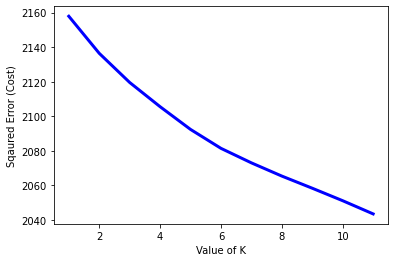

In [0]:
cost = []
for k in range(1,12):
    kmeanModel= KMeans(n_clusters=k,n_init=30,max_iter=200) 
    kmeanModel.fit(T_svd_res)
    cost.append(kmeanModel.inertia_) 
    print(k,cost[k-1])
plt.plot(range(1,12), cost, color ='b', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show()

# Clustering using K-means (with optimal value of K)

In [0]:
K = 5
kmeanModel= KMeans(n_clusters=K,verbose=0,n_init=30,max_iter=300)
kmeanModel.fit(T_svd_res)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=30, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
y_pred = kmeanModel.predict(T_svd_res)  

# Dimensionality reduction using T-SNE for cluster visualization

In [0]:
tsne = TSNE(n_components=2, perplexity=100, early_exaggeration=12.0, learning_rate=100.0,
                n_iter=700, n_iter_without_progress=300, min_grad_norm=1e-07, metric='euclidean',
                init='random', verbose=1, random_state=None, method='barnes_hut', angle=0.5, n_jobs=None)
tsne_results = tsne.fit_transform(tfidf)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 2225 samples in 7.247s...
[t-SNE] Computed neighbors for 2225 samples in 264.785s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2225
[t-SNE] Computed conditional probabilities for sample 2000 / 2225
[t-SNE] Computed conditional probabilities for sample 2225 / 2225
[t-SNE] Mean sigma: 0.342779
[t-SNE] KL divergence after 100 iterations with early exaggeration: 64.913712
[t-SNE] KL divergence after 700 iterations: 1.131006


In [0]:
clr = ['Blue','Green','Red','Darkgray','Yellow']
area = np.pi*7

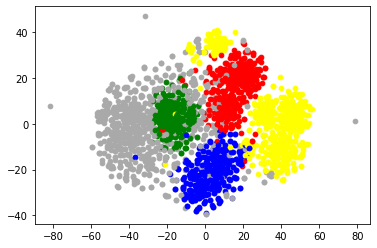

In [0]:
for i in range(tsne_results.shape[0]):
    X = tsne_results[:,0][i]
    Y = tsne_results[:,1][i]
    plt.scatter(X,Y,s=area,color=clr[y_pred[i]])
plt.show()

# Dimensionality reduction using UMAP for cluster visualization

In [0]:
UMAP_res = umap.UMAP(n_components=2,n_neighbors=301,min_dist=0.9,metric='cosine',n_epochs=200).fit_transform(tfidf)

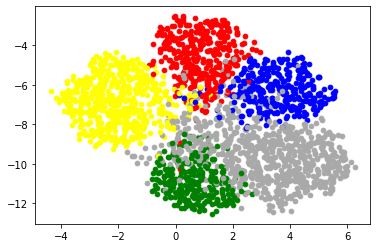

In [0]:
for i in range(UMAP_res.shape[0]):
    X = UMAP_res[:,0][i]
    Y = UMAP_res[:,1][i]
    plt.scatter(X,Y,s=area,color=clr[y_pred[i]])
plt.show()

# Dimensionality reduction using TruncatedSVD for cluster visualization

In [0]:
svd_res = TruncatedSVD(n_components=2,random_state = 0)
svd_res = svd_res.fit_transform(tfidf)

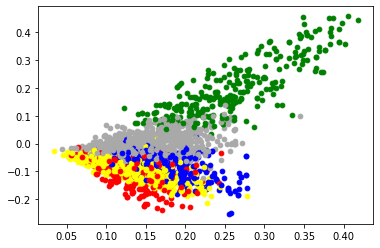

In [0]:
for i in range(svd_res.shape[0]):
    X = svd_res[:,0][i]
    Y = svd_res[:,1][i]
    plt.scatter(X,Y,s=area,color=clr[y_pred[i]])
plt.show()

# Preparing data for Embedding Projector
* Embedding Projector : http://projector.tensorflow.org

In [0]:
labels = y_pred[0:n_news]
labels = pd.DataFrame(labels)
labels.to_csv('/content/label.csv',index=False,header=False)

In [0]:
with open('/content/label.csv','r') as csvin, open('/content/label.txt', 'w') as tsvout:
    csvin = csv.reader(csvin)
    tsvout = csv.writer(tsvout, delimiter='\t')

    for row in csvin:
        tsvout.writerow(row)
pre, ext = os.path.splitext('/content/label.txt')
os.rename('/content/label.txt', pre + '.tsv')

In [0]:
tfidf_1 = umap.UMAP(n_components=200,n_neighbors=301,min_dist=0.9,metric='cosine',n_epochs=200).fit_transform(tfidf)

In [0]:
t = pd.DataFrame(tfidf_1[0:n_news].copy())
t.to_csv('/content/embed.csv',index=False,header=False) 

In [0]:
with open('/content/embed.csv','r') as csvin, open('/content/embed.txt', 'w') as tsvout:
    csvin = csv.reader(csvin)
    tsvout = csv.writer(tsvout, delimiter='\t')

    for row in csvin:
        tsvout.writerow(row)
pre, ext = os.path.splitext('/content/embed.txt')
os.rename('/content/embed.txt', pre + '.tsv')

# Embedding Projector Output(Screen Recording)


* **Visualization of clusters :**

<img src="https://github.com/amarsharma441/News-Articles-Clustering/blob/master/Embedding%20Projector%20-%20Visualization/Embedding%20projector%20-%20visualization%20of%20high-dimensional%20data_NEWS_CLUSTERS_1.gif?raw=true" width="2200" height="500">


* **Visualization of clusters (with labels):**

<img src="https://github.com/amarsharma441/News-Articles-Clustering/blob/master/Embedding%20Projector%20-%20Visualization/Embedding%20projector%20-%20visualization%20of%20high-dimensional%20data_NEWS_CLUSTERS_2.gif?raw=true" width="2300" height="550">

# Calculating Accuracy

In [0]:
dataframe['cluster'] = y_pred
dataframe.head()

,category,text,cluster
0,tech,tv future in the hand of viewer with home thea...,0
1,business,worldcom bos leave book alone former worldcom ...,3
2,sport,tiger wary of farrell gamble leicester say the...,4
3,sport,yeading face newcastle in fa cup premiership s...,4
4,entertainment,ocean s twelve raid box office ocean s twelve ...,2


In [0]:
dataframe.tail()

,category,text,cluster
2220,business,car pull down us retail figure us retail sale ...,3
2221,politics,kilroy unveils immigration policy exchatshow h...,1
2222,entertainment,rem announce new glasgow concert us band rem h...,2
2223,politics,how political squabble snowball it s become co...,3
2224,sport,souness delight at euro progress boss graeme s...,4


In [0]:
accuracy = 0
for i in range(K):
    temp_df = dataframe[dataframe['cluster'] == i]
    cat_mode = stats.mode(np.array(temp_df.category))
    print(cat_mode.mode[0],cat_mode.count[0],len(temp_df.category))
    accuracy = accuracy + (cat_mode.count[0]/len(temp_df.category))
print('Accuracy (Method 1) : '+str(round((accuracy/5)*100,2))+'%')     

accuracy2 = 0
category = ['entertainment','sport','tech','business','politics']
for i in category:
    temp_df = dataframe[dataframe['category'] == i]
    cat_mode = stats.mode(np.array(temp_df.cluster))
    print(cat_mode.mode[0],cat_mode.count[0],len(temp_df.cluster))
    accuracy2 = accuracy2 + (cat_mode.count[0]/len(temp_df.cluster))  
print('Accuracy (Method 2) : '+str(round((accuracy2/5)*100,2))+'%')     
print('Final Accuracy : '+str(round(((accuracy+accuracy2)/10)*100,2))+'%')        

tech 324 333
politics 274 277
entertainment 337 351
business 501 735
sport 497 529
Accuracy (Method 1) : 90.87%
2 337 386
4 497 511
0 324 401
3 501 510
1 274 417
Accuracy (Method 2) : 85.86%
Final Accuracy : 88.36%
